In [3]:
import pandas as pd
from pathlib import Path
import numpy as np

BASE = Path.cwd().parent if Path.cwd().name=="notebooks" else Path.cwd()
DATA = BASE/"data"/"processed"/"engineered_features_lag.csv"

df = pd.read_csv(DATA, parse_dates=["date"])
print("Shape:", df.shape)
df.head()


Shape: (993, 25)


,coin,symbol,price,1h,24h,7d,24h_volume,mkt_cap,date,source_file,...,liquidity_ratio_lag1,price_lag1,24h_volume_lag1,mkt_cap_lag1,price_ret_1d,vol_chg_1d,mcap_chg_1d,log_price,log_vol,log_mcap
0,0x,ZRX,0.509791,0.025,0.035,0.028,29309302.0,427933388.0,2022-03-16,coin_gecko_2022-03-16.csv,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.411971,17.193416,19.874478
1,0x,ZRX,0.518160,0.003,0.016,-0.010,24224308.0,439124277.0,2022-03-17,coin_gecko_2022-03-17.csv,...,0.068490,0.509791,29309302.0,427933388.0,0.016417,-0.173494,0.026151,0.417499,17.002867,19.900293
2,1inch,1INCH,1.500000,0.021,0.111,0.163,120457113.0,616145134.0,2022-03-16,coin_gecko_2022-03-16.csv,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.916291,18.606804,20.238993
3,1inch,1INCH,1.490000,0.008,-0.003,0.087,64145152.0,617505356.0,2022-03-17,coin_gecko_2022-03-17.csv,...,0.195501,1.500000,120457113.0,616145134.0,-0.006667,-0.467486,0.002208,0.912283,17.976659,20.241198
4,AIOZ Network,AIOZ,0.237396,0.047,0.287,0.241,13715452.0,114207956.0,2022-03-16,coin_gecko_2022-03-16.csv,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.213009,16.434034,18.553532


In [4]:
import joblib

features = [
    "price","1h","24h","7d","24h_volume","mkt_cap",
    "price_ma_3","price_ma_5","vol_3d",
    "liquidity_ratio_lag1","price_lag1","24h_volume_lag1","mkt_cap_lag1",
    "price_ret_1d","vol_chg_1d","mcap_chg_1d",
    "log_price","log_vol","log_mcap"
]

use = df.dropna(subset=["liquidity_ratio_lag1"]).copy()
X = use[features].fillna(0)
y = use["liquidity_ratio"].astype(float)

# Load best model (saved earlier)
MODEL_PATH = BASE/"artifacts"/"models"/"RidgeCV_logtarget.joblib"
model = joblib.load(MODEL_PATH)
print("Loaded model:", MODEL_PATH.name)


Loaded model: RidgeCV_logtarget.joblib


In [6]:
# Model was trained on log1p(target), so inverse transform
y_pred = np.expm1(model.predict(X))

results_df = pd.DataFrame({
    "coin": use["coin"],
    "date": use["date"],
    "actual": y,
    "predicted": y_pred
})

results_df.head(10)


,coin,date,actual,predicted
1,0x,2022-03-17,0.055165,0.073905
3,1inch,2022-03-17,0.103878,0.125376
5,AIOZ Network,2022-03-17,0.053256,0.064080
7,APENFT,2022-03-17,0.123973,0.126207
9,API3,2022-03-17,0.133236,0.102479
11,ARPA Chain,2022-03-17,0.201198,0.159243
13,Aave,2022-03-17,0.202411,0.143705
15,Aave [OLD],2022-03-17,0.000158,-0.020608
17,Aavegotchi,2022-03-17,0.246111,0.167322
19,Acala,2022-03-17,0.064324,0.075490


In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

rmse = np.sqrt(mean_squared_error(y, y_pred))
mae = mean_absolute_error(y, y_pred)
r2 = r2_score(y, y_pred)

print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")


RMSE: 0.0813, MAE: 0.0335, R²: 0.9541


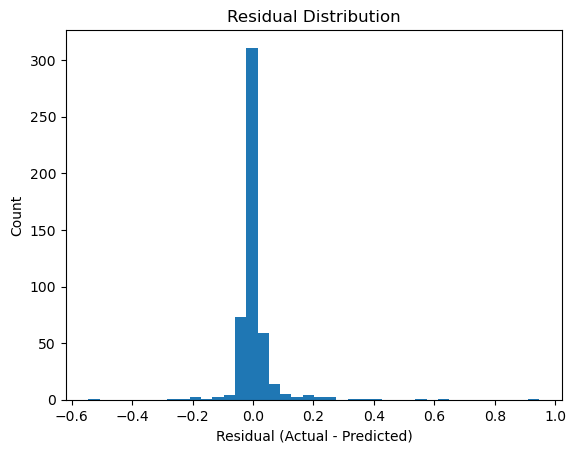

In [8]:
import matplotlib.pyplot as plt

residuals = y - y_pred

plt.hist(residuals, bins=40)
plt.title("Residual Distribution")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.show()


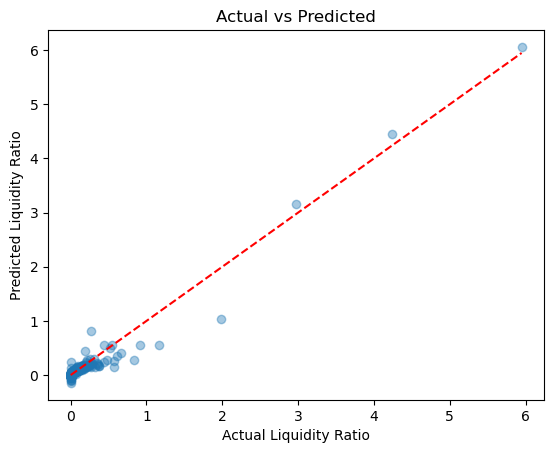

In [9]:
plt.scatter(y, y_pred, alpha=0.4)
plt.plot([y.min(), y.max()], [y.min(), y.max()], "r--")
plt.xlabel("Actual Liquidity Ratio")
plt.ylabel("Predicted Liquidity Ratio")
plt.title("Actual vs Predicted")
plt.show()
